# Data Challenge - Advanced Machine Learning


**The data challenge is proposed by Idemia**

## Description of the data challenge

You have at your disposal 100000 images of human faces, and their occlusion label.
The goal of this challenge is to regress the percentage of the face that is occluded (**target = variable continue**).
We also want to have similar performances on female and male, the gender label is given for the train database.

Below is the formula of the evaluation score. You'll first need to compute the error made by your model for men and women separetely. The error is measured as follows

$$
 Err = \frac{\sum_{i}{w_i(p_i - GT_i)^2}}{\sum_{i}{w_i}}, w_i = \frac{1}{30} + GT_i,
$$
where $GT_i$ is the ground truth and p_i the prediction made by your model. 

Then, the final score for the leaderboard is given by

$$
Score = \frac{Err_F + Err_M}{2} + \left | Err_F - Err_M \right |,
$$
where $Err_F$ and $Err_M$ are the errors obtained for female and men, respectively.

Hereafter we show you how to load the data and run a naive baseline using a pretrained model.

### Downloading the Data:

You can download the Dataset from the below links: https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax

In [2]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

### Load dataframes

In [20]:
# Load data
df_train = pd.read_csv("data/listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("data/listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "data/crops_100K"


In [11]:
df_train.head()

,filename,FaceOcclusion,gender
0,database1/img00011271.jpg,0.019,0.999
1,database1/img00012471.jpg,0.035,1.000
2,database1/img00008127.jpg,0.127,0.001
3,database1/img00008972.jpg,0.014,0.999
4,database1/img00028187.jpg,0.346,0.982


In [12]:
df_test.head()

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg


#### Remove nan values

In [13]:
df_train = df_train.dropna()
df_test = df_test.dropna()

### Split Dataframe in train and val

In [14]:
df_val = df_train.loc[:20000].reset_index()
df_train = df_train.loc[20000:].reset_index()

In [15]:
len(df_train), len(df_val), len(df_test)

(81341, 20001, 30507)

In [18]:
# Calculate lengths
len_train = len(df_train)
len_val = len(df_val)
len_test = len(df_test)

# Calculate total number of records in the original training set
total_records = len_train + len_val + len_test

# Calculate the percentages
percentage_train = (len_train / total_records) * 100
percentage_val = (len_val / total_records) * 100
percentage_test = (len_test / total_records) * 100

# Print the results
print(f"Percentage of training data: {percentage_train:.2f}%")
print(f"Percentage of validation data: {percentage_val:.2f}%")
print(f"Length of test data: {percentage_test:.2f}%")

Percentage of training data: 61.69%
Percentage of validation data: 15.17%
Length of test data: 23.14%


### Check that all images are read correctly

In [21]:
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    try:
        filename = df_train.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)
        
for idx, row in tqdm(df_test.iterrows(), total=len(df_test)):
    try:
        filename = df_test.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)

100%|██████████████████████████████| 30507/30507 [00:13<00:00, 2179.50it/s]


### Display first images

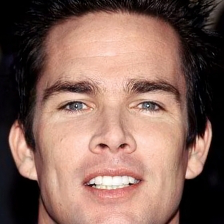

database1/img00011271.jpg 0.019 0.999


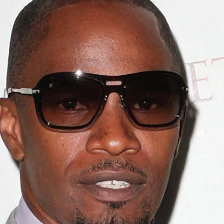

database1/img00012471.jpg 0.035 1.0


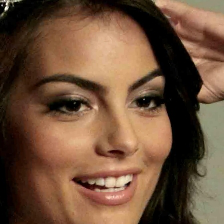

database1/img00008127.jpg 0.127 0.001


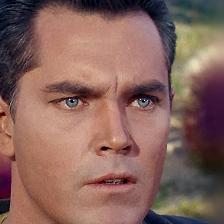

database1/img00008972.jpg 0.014 0.999


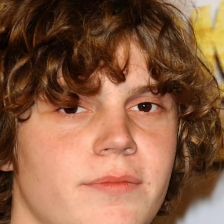

database1/img00028187.jpg 0.346 0.982


In [22]:
for idx, row in df_train[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

### Make Dataset and Dataloader

In [23]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename

In [26]:
training_set = Dataset(df_train, image_dir)
validation_set = Dataset(df_val, image_dir)

params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

### Create naive model

In [25]:
# model = torchvision.models.mobilenet_v3_small(num_classes=1) # Naive baseline
model = models.efficientnet_b0(pretrained=True) # Yuchen efficientnet
if torch.cuda.is_available():
    model.cuda()    
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Loss and optimizer

In [27]:
loss_fn = nn.MSELoss()

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train naive model

In [29]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#### Fit on train split

In [30]:
num_epochs = 1

for n in range(num_epochs):
    print(f"Epoch {n}")
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

Epoch 0



  0%|                                            | 0/12669 [00:00<?, ?it/s]

tensor(0.0266, grad_fn=<MseLossBackward0>)


  2%|▌                               | 201/12669 [01:02<1:01:57,  3.35it/s]

tensor(0.0042, grad_fn=<MseLossBackward0>)


  3%|█                                 | 401/12669 [02:07<59:57,  3.41it/s]

tensor(0.0073, grad_fn=<MseLossBackward0>)


  5%|█▌                                | 601/12669 [03:06<58:34,  3.43it/s]

tensor(0.0099, grad_fn=<MseLossBackward0>)


  6%|██▏                               | 801/12669 [04:03<55:12,  3.58it/s]

tensor(0.0057, grad_fn=<MseLossBackward0>)


  8%|██▍                            | 1000/12669 [05:02<1:36:40,  2.01it/s]

tensor(0.0044, grad_fn=<MseLossBackward0>)


  9%|███▏                             | 1201/12669 [06:04<55:34,  3.44it/s]

tensor(0.0042, grad_fn=<MseLossBackward0>)


 11%|███▋                             | 1401/12669 [07:01<54:08,  3.47it/s]

tensor(0.0028, grad_fn=<MseLossBackward0>)


 13%|████▏                            | 1601/12669 [08:00<53:27,  3.45it/s]

tensor(0.0190, grad_fn=<MseLossBackward0>)


 14%|████▋                            | 1801/12669 [08:59<52:11,  3.47it/s]

tensor(0.0013, grad_fn=<MseLossBackward0>)


 16%|█████▏                           | 2001/12669 [10:01<49:22,  3.60it/s]

tensor(0.0066, grad_fn=<MseLossBackward0>)


 17%|█████▋                           | 2201/12669 [10:58<49:43,  3.51it/s]

tensor(0.0030, grad_fn=<MseLossBackward0>)


 19%|██████▎                          | 2401/12669 [11:55<48:23,  3.54it/s]

tensor(0.0040, grad_fn=<MseLossBackward0>)


 21%|██████▊                          | 2601/12669 [12:52<48:15,  3.48it/s]

tensor(0.0037, grad_fn=<MseLossBackward0>)


 22%|███████▎                         | 2801/12669 [13:49<48:20,  3.40it/s]

tensor(0.0011, grad_fn=<MseLossBackward0>)


 24%|███████▊                         | 3001/12669 [14:46<44:56,  3.59it/s]

tensor(0.0047, grad_fn=<MseLossBackward0>)


 25%|████████▎                        | 3201/12669 [15:42<42:41,  3.70it/s]

tensor(0.0031, grad_fn=<MseLossBackward0>)


 27%|████████▊                        | 3401/12669 [16:39<42:33,  3.63it/s]

tensor(0.0031, grad_fn=<MseLossBackward0>)


 28%|█████████▏                       | 3507/12669 [17:09<44:49,  3.41it/s]

('database3/database3/m.01csvq/66-FaceId-0_align.jpg', 'database3/database3/m.0178j_/62-FaceId-0_align.jpg', 'database3/database3/m.01d1nj/28-FaceId-0_align.jpg', 'database3/database3/m.01dqbx/57-FaceId-0_align.jpg', 'database1/img00012025.jpg', 'database1/img00023917.jpg', 'database3/database3/m.018dpq/68-FaceId-0_align.jpg', 'database3/database3/m.015qv9/75-FaceId-0_align.jpg')
label tensor([[0.2660],
        [   nan],
        [0.0010],
        [0.0380],
        [0.0180],
        [0.2670],
        [0.1220],
        [0.1240]])
y_pred tensor([[0.2873],
        [0.0699],
        [0.0097],
        [0.0466],
        [0.0368],
        [0.0629],
        [0.1444],
        [0.0206]], grad_fn=<AddmmBackward0>)


## Evaluate metric on validation split

In [31]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [5]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

NameError: name 'tqdm' is not defined

In [4]:
results_df.head()

NameError: name 'results_df' is not defined

In [3]:
results_df['pred'].hist()

NameError: name 'results_df' is not defined

In [1]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]

NameError: name 'results_df' is not defined

In [ ]:
metric_fn(results_male, results_female)

## Evaluating your Test DataSet

In [ ]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [ ]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [ ]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

In [ ]:
test_df.head()

### Preparing your file for Submission

In [ ]:
test_df.to_csv("Data_Challenge.csv", header = None, index = None)

#### Now it's your turn. Good luck !  :) 